# Trabalho Prático 1: Geometria Computacional

Filipe Pirola Santos - 2021031580

Igor Eduardo Martins Braga - 2022425671

Wallace Eduardo Pereira - 2021032013

# Bibliotecas


Durante a realização do trabalho utilizamos alguns datasets da plataforma UC Irvine Machine Learning Repository e, para isso, tivemos que instalar a seguinte dependência no notebook para importar datasets diretamente em python:

In [1]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns

# Algoritmos

**Algoritmo de envoltória convexa**

Este algoritmo calcula a envoltória convexa de um conjunto de pontos usando o algoritmo de Graham.

Primeiramente, o algoritmo começa encontrando o ponto de ancoragem, que é o ponto com a menor coordenada y (e mais à esquerda em caso de empate). Em seguida, ele classifica os pontos com base no ângulo polar em relação ao ponto de ancoragem.

Os dois primeiros pontos na lista classificada são adicionados à envoltória convexa. Em seguida, o algoritmo itera pelos pontos ordenados, verificando se eles fazem parte da envoltória convexa. Ele faz isso verificando o sentido da orientação dos pontos em relação ao último ponto adicionado à envoltória. Se o ponto estiver à esquerda da envoltória, ele é adicionado; caso contrário, os pontos são removidos da envoltória até que o ponto certo seja encontrado.

O algoritmo termina quando todos os pontos ordenados foram processados, e a envoltória convexa é retornada como uma lista de pontos ordenados que a compõem. Isso fornece uma representação concisa da envoltória convexa que envolve o conjunto de pontos de entrada.

Decidimos escolher esse algoritmo por ser mais eficiente, ao utilizar a ideia de ordenar os pontos. Assim, essa lista é calulada uma vez e percorremos-a uma unica vez para calcular a envoltória convexa.

In [3]:
## @brief Calcula a orientação dos pontos
## @param q, p, r Pontos no plano
def orientation(p1, p2, p3):

    result = (p2[1] - p1[1]) * (p3[0] - p2[0]) - (p2[0] - p1[0]) * (p3[1] - p2[1])

    if result == 0:
        return 0  # Os pontos são colineares

    if result > 0:
      return 1
    else:
      return 2

In [4]:
## @brief Calcula a envoltória convexa utilizando o algoritmo de Graham
## @param pontos Conjunto de pontos analisados
def getConvexHull(points):

    n = len(points)

    # Caso tenha menos que três pontos não é possivel criar a envoltória convexa
    if n < 3:
        return points

    # Encontrar o ponto com a menor coordenada y (e mais à esquerda, se houver empate) (âncora)
    pivot = min(points, key=lambda x: (x[1], x[0]))

    # Ordenar os pontos com base no ângulo polar em relação ao âncora
    sortedPoints = sorted(points, key=lambda x: (math.atan2(x[1] - pivot[1], x[0] - pivot[0]), x))

    p1 = sortedPoints[0]
    p2 = sortedPoints[1]

    # Inicializar a envoltória convexa com a âncora e os dois primeiros pontos ordenados
    convexHull = [pivot, p1, p2]

    # Iterar pelos pontos ordenados para encontrar a envoltória convexa
    for i in range(2, n):
        while len(convexHull) > 1 and orientation(convexHull[-2], convexHull[-1], sortedPoints[i]) != 2:
            convexHull.pop()
        convexHull.append(sortedPoints[i])

    return convexHull

**Algoritmo de Varredura Linear**

Este algoritmo `doIntersect` é usado para verificar se dois segmentos de linha, definidos por pares de pontos (p1, q1) e (p2, q2), se intersectam ou se cruzam. Ele segue a lógica de determinar a orientação dos pontos em relação a outros pontos e, com base nisso, decide se há interseção.

O algoritmo verifica a orientação de quatro combinações de pontos, se `o1` é diferente de `o2` e `o3` é diferente de `o4`, então os segmentos se intersectam. Essa é a condição geral para interseção. Existem casos especiais para quando os pontos estão colineares. Caso contrário, se nenhuma das condições acima for atendida, os segmentos não se intersectam, e a função retorna `False`.

A função `isOnSegment` é usada para verificar os casos especiais, ou seja, se um ponto `q` está no segmento de linha definido pelos pontos `p` e `r`.

In [5]:
def doIntersect(p1, q1, p2, q2):
    # Verifica se os segmentos p1q1 e p2q2 se intersectam
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # Casos gerais
    if o1 != o2 and o3 != o4:
        return True

    # Casos especiais
    if o1 == 0 and isOnSegment(p1, p2, q1):
        return True
    if o2 == 0 and isOnSegment(p1, q2, q1):
        return True
    if o3 == 0 and isOnSegment(p2, p1, q2):
        return True
    if o4 == 0 and isOnSegment(p2, q1, q2):
        return True

    return False

def isOnSegment(p, q, r):
    # Verifique se o ponto q está no segmento formado por p e r
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

**Separabilidade linear**

O algoritmo `separavelLinear` tem como finalidade verificar se duas envoltórias convexas, representadas por conjuntos de pontos `convexHullA` e `convexHullB`, são linearmente separáveis, ou seja, se elas não se sobrepõem ou cruzam umas às outras. O algoritmo itera por todos os lados (arestas) da envoltória convexa A e verifica se algum deles cruza com qualquer lado da envoltória convexa B usando a função `doIntersect`, que determina a interseção entre segmentos de linha. Vamos essa verificação para determinar se duas regiões definidas por envoltórias convexas não se sobrepõem, ou seja, se são linearmente separáveis.

In [6]:
# Função para verificar a interseção entre duas envoltórias convexas
def separavelLinear(convexHullA, convexHullB):
    nA = len(convexHullA)
    nB = len(convexHullB)
    for i in range(nA):
        for j in range(nB):
            if doIntersect(convexHullA[i], convexHullA[(i + 1) % nA], convexHullB[j], convexHullB[(j + 1) % nB]):
                return False
    return True

# **Modelo**

Após decidir se os dados são linearmente separáveis, podemos construir um modelo para classificar novos valores do conjunto.

**Pontos mais próximos da envoltória**

O algoritmo começa inicializando uma variável `closestPair` como `None` para representar o par mais próximo encontrado e uma variável `closestDistance` como infinito para representar a distância entre os pontos do par mais próximo.

Ele itera por todos os pontos da envoltória convexa `convexHullA` e, para cada ponto `pointA`, itera por todos os pontos da envoltória convexa `convexHullB`. Calcula a distância ao quadrado entre `pointA` e `pointB` usando a função `squaredDistance`. Se a distância calculada for menor que a `closestDistance` atual, atualiza `closestPair` para o novo par mais próximo encontrado e atualiza `closestDistance` para a nova distância.

Ao final das iterações, a função retorna o par de pontos mais próximos encontrado, representado por `closestPair`.

In [7]:
## @brief Calcula a distancia euclidiana entre um par de pontos
## @param point_1, point_2 Par de pontos
def squaredDistance(pointA, pointB):
  x1, y1 = pointA
  x2, y2 = pointB
  return (x1 - x2)**2 + (y1 - y2)**2

In [8]:
## @brief Encontra o par de pontos mais próximo entre as duas envoltórias
## @param convex_hull_1, convex_hull_2 Envoltórias convexas
def getClosestPair(convexHullA, convexHullB):
  closestPair = None
  closestDistance = float('inf')

  for pointA in convexHullA:
    for pointB in convexHullB:
      distance = squaredDistance(pointA, pointB)
      if distance < closestDistance:
        closestPair = (pointA, pointB)
        closestDistance = distance

  return closestPair

**Reta que divide os dois grupos**

Essa função `getBisector` tem como objetivo encontrar a reta bissetriz entre um par de pontos definidos por suas coordenadas cartesianas (x1, y1) e (x2, y2).

1. A função começa encontrando o ponto médio do segmento, que é o ponto entre os dois pontos de entrada. O ponto médio é calculado tomando a média das coordenadas x e y dos dois pontos.

2. Em seguida, a função calcula o vetor direção do segmento (AB), que é definido como a diferença entre as coordenadas do segundo ponto e as coordenadas do primeiro ponto (x2 - x1, y2 - y1).

3. A reta bissetriz é encontrada calculando um vetor perpendicular ao vetor direção do segmento. Isso é feito trocando as coordenadas x e y do vetor direção, negando uma delas. O vetor resultante é, então, normalizado dividindo suas coordenadas pela magnitude (ou comprimento) do vetor.

4. A função define os pontos finais da reta bissetriz, estendendo-a a partir do ponto médio. O comprimento da reta bissetriz é definido como 10 (mas pode ser ajustado conforme necessário).

5. A função retorna a equação da reta bissetriz em termos de seus pontos finais (endPointAX, endPointAY) e (endPointBX, endPointBY). Para isso, faz uso de outra função chamada `getLinearEquation` para calcular a equação da reta com base em dois pontos.

In [9]:
## @brief Calcula os parâmetros da reta gerada por um par de pontos
## @param x1, y1, x2, y2 Coordenadas cartersianas de um par de pontos
def getLinearEquation(x1, y1, x2, y2):
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return a, b

In [10]:
## @brief Encontra a reta bissetriz entre um par de pontos
## @param x1, y1, x2, y2 Coordenadas cartersianas de um par de pontos
def getBisector(x1, y1, x2, y2):
    # Encontrar o ponto médio do segmento
    midpointX = (x1 + x2) / 2
    midpointY = (y1 + y2) / 2

    # Calcular o vetor direção do segmento AB
    ABX = x2 - x1
    ABY = y2 - y1

    # Calcular o vetor direção da reta bissetriz
    bissetorX = -ABY
    bissetorY = ABX

    # Normalizar o vetor bissetriz
    length = np.sqrt(bissetorX**2 + bissetorY**2)
    bissetorX /= length
    bissetorY /= length

    # Definir os pontos finais da bissetriz
    length = 10  # Comprimento da reta bissetriz
    endPointAX = midpointX - length * bissetorX
    endPointAY = midpointY - length * bissetorY
    endPointBX = midpointX + length * bissetorX
    endPointBY = midpointY + length * bissetorY

    return getLinearEquation(endPointAX, endPointAY, endPointBX, endPointBY)

**Classificar os pontos**

A função `classifyData` tem como objetivo classificar um conjunto de pontos em relação a uma reta modelo definida pelos parâmetros `a` e `b`. Ela percorre cada ponto no conjunto, calcula o valor esperado `y_expected` com base na reta modelo e compara esse valor com o valor real de `y`. A partir dessa comparação, a função atribui uma classificação ao ponto, sendo 1 se o ponto está acima da reta, -1 se está abaixo e 0 se está na reta. O resultado é uma lista de classificações para cada ponto no conjunto.

In [11]:
## @brief Classifica um conjunto de pontos em relação a uma reta modelo
## @param a, b Parâmetros da reta modelo
##        point Conjunto de pontos a ser classificado
def classifyData(a, b, point):
  # Inicializar listas para classificação e cores
  classification = []

  # Classificar e atribuir cores aos pontos
  for x, y in point:
      y_expected = a * x + b
      if y > y_expected:
          classification.append(1)
      elif y < y_expected:
          classification.append(-1)
      else:
          classification.append(0)

  return classification

**Função auxiliar para plotar o modelo, usada no exemplo**

In [12]:
## @brief Plota o modelo linear que classifica os dados
## @param convexHullA, convexHullB Envoltórias convexas calculadas para cada grupo
##        groupA, groupB Grupo de dados do problema
##        closestPair Par de pontos mais próximos entre as duas envoltórias
##        nameGroupA, nameGroupB Label dado a cada grupo
def plotModel(convexHullA, convexHullB, groupA, groupB, closestPair):
  plt.scatter(*zip(*groupA), label='Grupo A', c='b', marker='o')
  plt.scatter(*zip(*groupB), label='Grupo B', c='r', marker='o')

  # Plotar a envoltória convexa em si
  xA, yA = zip(*convexHullA)
  xB, yB = zip(*convexHullB)
  plt.plot(xA + (xA[0],), yA + (yA[0],), c='g', linewidth=1)
  plt.plot(xB + (xB[0],), yB + (yB[0],), c='g', linewidth=1)

  # Plotar os pontos mais próximos destacados
  (x1, y1), (x2, y2) = closestPair
  plt.plot([x1, x2], [y1, y2], marker="o", markersize=10)

  # Plotar a reta que divide os dois grupos (bissetriz)
  a, b = getBisector(x1, y1, x2, y2)
  x_line = [x1, x2]
  y_line = [a * x + b for x in x_line]
  plt.plot(x_line, y_line, label=f'y = {a:.2f}x + {b:.2f}', color='orange')

  plt.title('Modelo para classificação dos dados')
  plt.legend()
  plt.grid(True)
  plt.show()

**Métricas**

As três funções `precision_score`, `recall_score` e `f1_score` são métricas comumente usadas para avaliar o desempenho de modelos de classificação. Elas estão relacionadas à matriz de confusão, que é uma tabela que compara as previsões de um modelo com os valores reais dos dados.

Em resumo, essas três métricas fornecem diferentes perspectivas sobre o desempenho de um modelo de classificação. A precisão mede a precisão das previsões positivas, a revocação mede a capacidade do modelo de encontrar exemplos positivos e o F1-Score combina essas duas métricas em um único valor que reflete o equilíbrio entre precisão e revocação.

In [13]:
def metrics(realPrev, modelPrev):
  print('\nPrecisão: ', precision_score(realPrev, modelPrev), '\nRevocação: ', recall_score(realPrev, modelPrev), '\nF1-score: ', f1_score(realPrev, modelPrev))

**Função geral**

Com essa função, é possível obter o modelo para os novos dados, com base nos dois grupos utilizados como parâmetro.

In [14]:
## @brief Realiza os passos necessários para o trabalho funcionar
## @param groupA, groupB Amostras usadas para criar o modelo
##        newGroup Amostras usadas para testar o modelo
def main(groupA, groupB, testGroup, realPrev):

  # Encontrar a envoltória convexa dos pontos
  convexHullA = getConvexHull(groupA)
  convexHullB = getConvexHull(groupB)

  # Checa se os grupos são linearmente separáveis
  if separavelLinear(convexHullA, convexHullB):

    # Encontra os dois pontos mais próximos da envoltória
    closestPair = getClosestPair(convexHullA, convexHullB)
    (cx1, cy1), (cx2, cy2) = closestPair

    # Gera o modelo que descreve os dados
    a, b = getBisector(cx1, cy1, cx2, cy2)

    # Classifica os novos pontos
    modelPrev = classifyData(a, b, testGroup)

    # Imprime o modelo
    plotModel(convexHullA, convexHullB, groupA, groupB, closestPair)

    # Checa a acurácia do modelo
    metrics(realPrev, modelPrev)

  else:
    print("Os dados não são separáveis linearmente.")

# Tratamento dos dados

Precisamos tratar os datasets utilizados para se adequar ao propósito do projeto.

**Função de redução dimensional**

Essa função tem como objetivo reduzir a dimensionalidade de um conjunto de dados.

Em primeiro lugar, aplicamos o PCA (Principal Component Analysis) nos dados. PCA é uma técnica de redução de dimensionalidade que ajuda a preservar a maior parte da variação dos dados em um número menor de dimensões.

Em segundo lugar, antes de aplicar o PCA, os dados são padronizados usando o StandardScaler. A padronização é importante em PCA para garantir que todas as variáveis tenham a mesma escala, o que é crucial para o funcionamento adequado do PCA. A padronização transforma as variáveis para que tenham média zero e desvio padrão igual a um, o que ajuda a evitar que as variáveis com escalas maiores dominem o resultado do PCA.

Por fim, os resultados da redução de dimensionalidade com PCA são armazenados em um DataFrame chamado `reducedData`, que contém duas colunas, "X" e "Y". Isso é útil para visualização e análise subsequente dos dados em um espaço bidimensional.

In [15]:
def normalized_reduce_dimension_dataset(data):
  pca = PCA(n_components=2)
  data = StandardScaler().fit_transform(data)
  components = pca.fit_transform(data)
  reducedData = pd.DataFrame(data=components, columns=["X", "Y"])

  return reducedData

**Função de importação de datasets**

A função `import_uci` é destinada a importar conjuntos de dados da UCI (Universidade da Califórnia, Irvine) Machine Learning Repository.

In [16]:
def import_uci(id):
    dataframe = fetch_ucirepo(id=id)
    features = dataframe.data.features
    targets = dataframe.data.targets
    return features, targets

# Exemplo de geração do modelo

Vamos gerar um conjunto de pontos simples linearmente separáveis simples para tornar mais fácil a compreensão dos algoritmos implementados.


**Gera pontos 40 pontos linearmente separáveis**

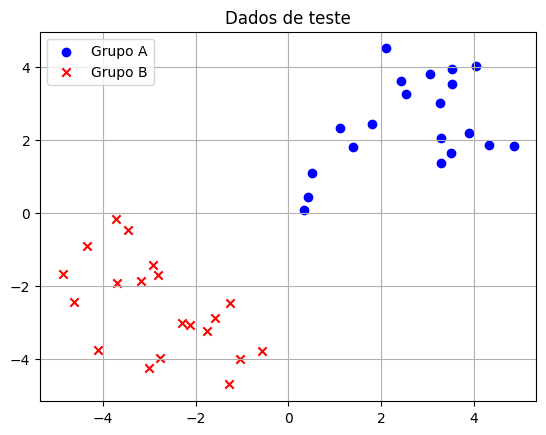

In [17]:
# Geramos 40 pontos aleatórios linearmente separáveis
groupA = [(random.uniform(0, 5), random.uniform(0, 5)) for _ in range(20)]
groupB = [(random.uniform(-5, 0), random.uniform(-5, 0)) for _ in range(20)]

# Plotamos o gráfico
plt.title('Dados de teste')
plt.scatter(*zip(*groupA), label='Grupo A', c='b', marker='o')
plt.scatter(*zip(*groupB), label='Grupo B', c='r', marker='x')
plt.legend()
plt.grid(True)
plt.show()

**Calcula a envoltória convexa dos grupos**

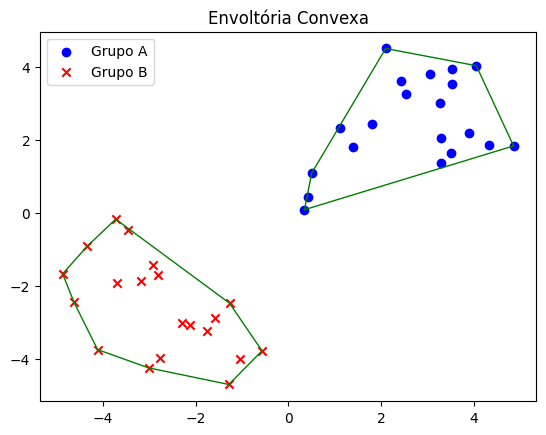

In [18]:
# Encontrar a envoltória convexa dos pontos
convexHullA = getConvexHull(groupA)
convexHullB = getConvexHull(groupB)

# Separar coordenadas x e y para plotagem
xA, yA = zip(*convexHullA)
xB, yB = zip(*convexHullB)

# Plotar os pontos de entrada
plt.scatter(*zip(*groupA), label='Grupo A', c='b', marker='o')
plt.scatter(*zip(*groupB), label='Grupo B', c='r', marker='x')

# Plotar a envoltória convexa
plt.plot(xA + (xA[0],), yA + (yA[0],), c='g', linewidth=1)
plt.plot(xB + (xB[0],), yB + (yB[0],), c='g', linewidth=1)

plt.title('Envoltória Convexa')
plt.legend()
plt.show()

**Testa se os grupos são linearmente separáveis**

In [19]:
if separavelLinear(convexHullA, convexHullB):
    print("Não há interseções entre os conjuntos A e B.")
else:
    print("Há interseções entre os conjuntos A e B.")

Não há interseções entre os conjuntos A e B.


**Encontra o modelo para classificar futuros pontos**

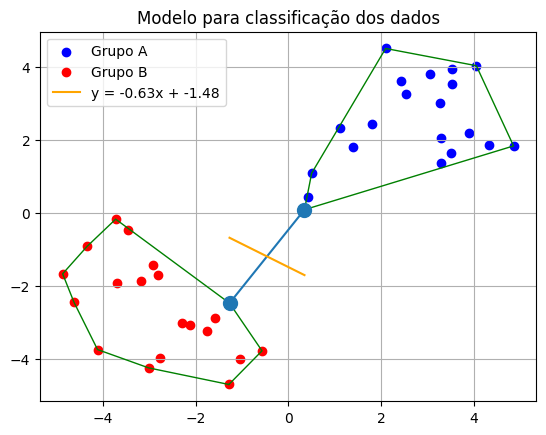

In [20]:
closestPair = getClosestPair(convexHullA, convexHullB)
plotModel(convexHullA, convexHullB, groupA, groupB, closestPair)

Com isso, podemos ver a implementação completa do modelo, seguindo o passo a passo estipulado pela documentação do trabalho.

# **Testes**

**TESTE 1 - Dataset Iris**

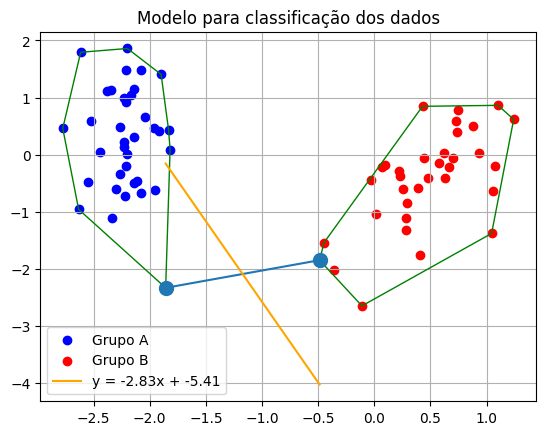


Precisão:  0.8888888888888888 
Revocação:  1.0 
F1-score:  0.9411764705882353


In [24]:
from sklearn.datasets import load_iris

# Carregando dataset Iris
iris = load_iris()

# Diminuindo para duas dimensões
irisDf = normalized_reduce_dimension_dataset(iris.data)

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
irisDf['Class'] = iris.target

# Filtragem em dois grupos
irisFiltered = irisDf[irisDf['Class'] != 2]

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(irisFiltered, test_size=0.3, random_state=40)

groupA = trainData[trainData['Class'] == 0]
groupB = trainData[trainData['Class'] == 1]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == 0 else 1 if x == 1 else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 2 - Dataset wine**

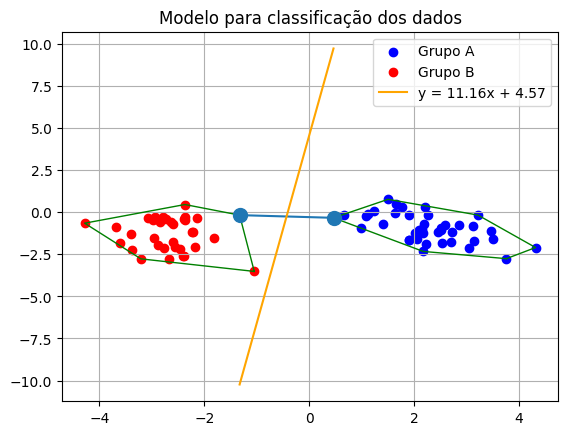


Precisão:  1.0 
Revocação:  1.0 
F1-score:  1.0


In [25]:
from sklearn.datasets import load_wine

# Carregando dataset Wine
wine = load_wine()

# Diminuindo para duas dimensões
wineDf = normalized_reduce_dimension_dataset(wine.data)

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
wineDf['Class'] = wine.target

# Filtragem em dois grupos
wineFiltered = wineDf[wineDf['Class'] != 1]

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(wineFiltered, test_size=0.3, random_state=42)

groupA = trainData[trainData['Class'] == 0]
groupB = trainData[trainData['Class'] == 2]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [1 if x == 2 else -1 if x == 0 else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 3 - Digits Dataset**

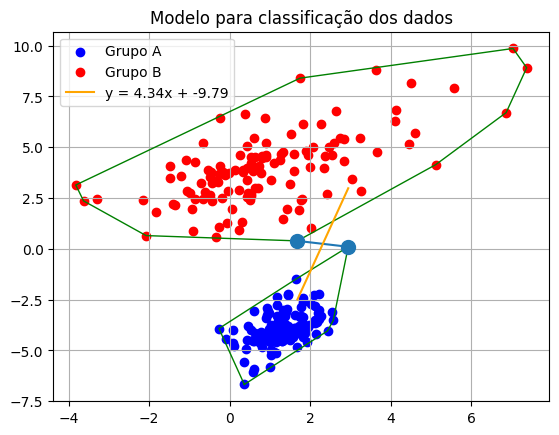


Precisão:  0.6265060240963856 
Revocação:  0.9454545454545454 
F1-score:  0.753623188405797


In [26]:
from sklearn.datasets import load_digits

# Carregando dataset Digits
digits = load_digits()

# Diminuindo para duas dimensões
digitsDf = normalized_reduce_dimension_dataset(digits.data)

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
digitsDf['Class'] = digits.target

# Filtragem em dois grupos
digitsFiltered = digitsDf[(digitsDf['Class'] == 6) | (digitsDf['Class'] == 7)]

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(digitsFiltered, test_size=0.3, random_state=123)

groupA = trainData[trainData['Class'] == 6]
groupB = trainData[trainData['Class'] == 7]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == 6 else 1 if x == 7 else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 4 - Dataset Breast Cancer**

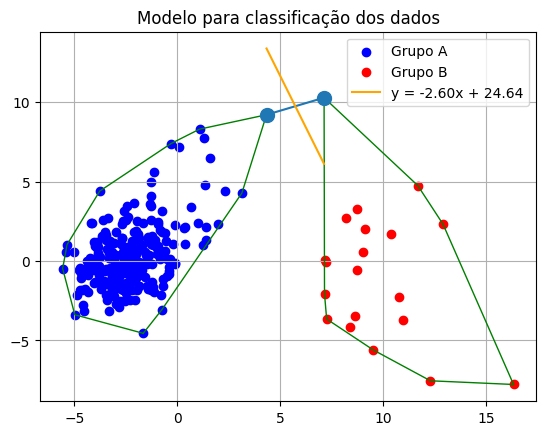


Precisão:  1.0 
Revocação:  0.25 
F1-score:  0.4


In [27]:
from sklearn.datasets import load_breast_cancer

# Carregando dataset BreastCancer
breastCancer = load_breast_cancer()

# Diminuindo para duas dimensões
breastCancerDf = normalized_reduce_dimension_dataset(breastCancer.data)

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
breastCancerDf['Class'] = breastCancer.target

# Pegando o ponto mais à direita da classe 1
right_point = breastCancerDf[breastCancerDf['Class'] == 1].max()['X']

# Apagar pontos da classe 0 que estão à esquerda do ponto mais à direita da classe 1
filtered_breast_cancer = breastCancerDf[(breastCancerDf['Class'] != 0) | (breastCancerDf['X'] >= right_point)]

# Encontrar o ponto mais acima (eixo Y) da classe 1
highest_y = filtered_breast_cancer[filtered_breast_cancer['Class'] == 1]['Y'].max()

# Apagar ponto mais acima encontrado
filtered_breast_cancer = filtered_breast_cancer.drop(filtered_breast_cancer[(filtered_breast_cancer['Class'] == 1) & (filtered_breast_cancer['Y'] == highest_y)].index)

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(filtered_breast_cancer, test_size=0.3, random_state=123)

groupA = trainData[trainData['Class'] == 1]
groupB = trainData[trainData['Class'] == 0]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == 1 else 1 if x == 0 else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 5 - DryBean Dataset**

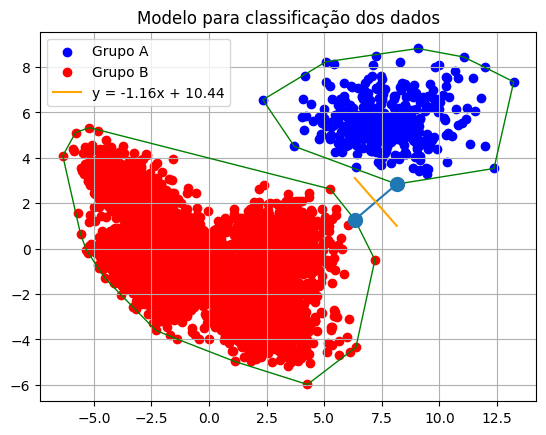


Precisão:  1.0 
Revocação:  0.9736842105263158 
F1-score:  0.9866666666666666


In [28]:
# Carregando dataset DryBean
features, targets = import_uci(602)

# Diminuindo para duas dimensões
dry_bean_df = normalized_reduce_dimension_dataset(features)

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
dry_bean_df['Class'] = targets

# Removendo classe "BARBUNYA" do dataFrame
dry_bean_df = dry_bean_df[dry_bean_df['Class'] != "BARBUNYA"]

# Criando cópia do dataframe para fazer alterações
dry_bean_df_filtered = dry_bean_df.copy()

# Classificar todos os pontos diferentes da classe "BOMBAY" de "Other Group"
dry_bean_df_filtered.loc[dry_bean_df_filtered['Class'] != "BOMBAY", 'Class'] = "Other Group"

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(dry_bean_df_filtered, test_size=0.3, random_state=52)

# Separação dos dados em dois grupos
groupA = trainData[trainData['Class'] == "BOMBAY"]
groupB = trainData[trainData['Class'] == "Other Group"]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == "Other Group" else 1 if x == "BOMBAY" else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 6 - Olivetti DataSet**

In [29]:
from sklearn.datasets import fetch_olivetti_faces

# Carregando dataset
olivetti_faces = fetch_olivetti_faces()

olivetti_faces_data = olivetti_faces.data

# Diminuindo para duas dimensões
olivetti_faces_df = normalized_reduce_dimension_dataset(olivetti_faces_data)

# Adicionando coluna de classe (target) no dataset reduzido dimensionalmente
olivetti_faces_df['Class'] = olivetti_faces.target

olivetti_faces_filtered = olivetti_faces_df[(olivetti_faces_df["Class"] == 4) | (olivetti_faces_df["Class"] == 1)]

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(olivetti_faces_filtered, test_size=0.3, random_state=10)

# Separação dos dados em dois grupos
groupA = trainData[trainData['Class'] == 4]
groupB = trainData[trainData['Class'] == 1]

# Separando os pontos dos grupos
groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == 4 else 1 if x == 1 else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

Os dados não são separáveis linearmente.


**TESTE 7 - Rice DataSet**

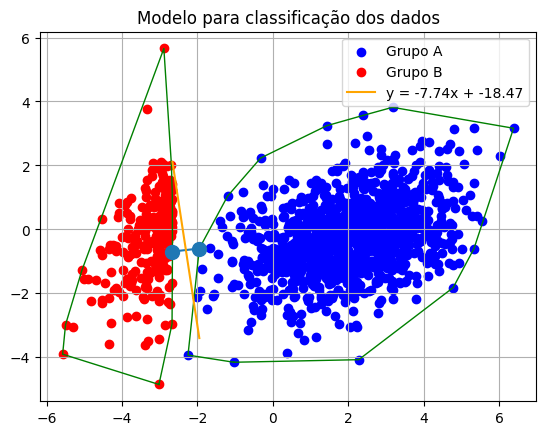


Precisão:  1.0 
Revocação:  0.9959016393442623 
F1-score:  0.997946611909651


In [30]:
features, targets = import_uci(545)

rice_df = normalized_reduce_dimension_dataset(features)

rice_df['Class'] = targets

# Selecionar ponto mais à esqueda da classe "Cammeo"
cammeo_leftmost_point = rice_df[rice_df['Class'] == 'Cammeo'].min()['X']

# Apagar pontos à direita do ponto mais à esquerda de "Cammeo" para a classe "Osmancik"
filtered_rice_df = rice_df[(rice_df['Class'] != 'Osmancik') | (rice_df['X'] <= cammeo_leftmost_point)]

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(filtered_rice_df, test_size=0.3, random_state=13)

groupA = trainData[trainData['Class'] == "Cammeo"]
groupB = trainData[trainData['Class'] == "Osmancik"]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [1 if x == "Cammeo" else -1 if x == "Osmancik" else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 8 - Lung Cancer**

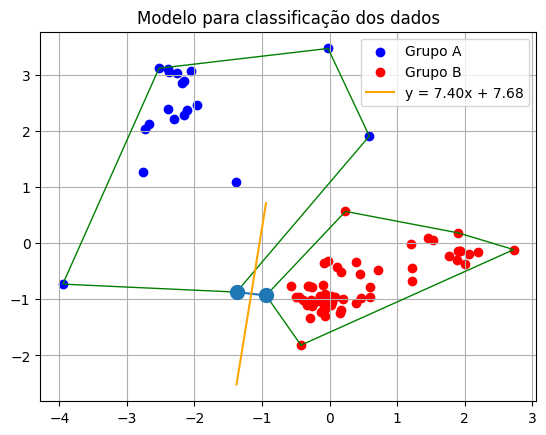


Precisão:  1.0 
Revocação:  1.0 
F1-score:  1.0


In [31]:
features, targets = import_uci(42)

lung_cancer_df = normalized_reduce_dimension_dataset(features)

lung_cancer_df['Class'] = targets

# Seleciona as classes 7, 1 e 3 do dataframe
lung_cancer_df = lung_cancer_df[(lung_cancer_df['Class'] == 7) | (lung_cancer_df['Class'] == 1) | (lung_cancer_df['Class'] == 3)]

# Fazer uma cópia do dataframe
new_lung_cancer_df = lung_cancer_df.copy()

# Classificar todos os pontos diferentes da classe 7 de "Other Group"
new_lung_cancer_df.loc[new_lung_cancer_df['Class'] != 7, 'Class'] = "Other Group"

# Selecionar ponto mais à direita da classe 7
rightmost_point = new_lung_cancer_df[new_lung_cancer_df['Class'] == 7].max()['X']

# Remover o ponto mais à direita da classe 7
lung_cancer_filtered = new_lung_cancer_df.drop(new_lung_cancer_df[(new_lung_cancer_df['Class'] == 7) & (new_lung_cancer_df['X'] == rightmost_point)].index)

# Separando os dados em teste e treinamento
trainData, testData = train_test_split(lung_cancer_filtered, test_size=0.3, random_state=42)

groupA = trainData[trainData['Class'] == 7]
groupB = trainData[trainData['Class'] == "Other Group"]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [1 if x == 7 else -1 if x == "Other Group" else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

**TESTE 9 - Letter recognition**

In [32]:
features, targets = import_uci(59)

letter_recognition_df = normalized_reduce_dimension_dataset(features)

letter_recognition_df['Class'] = targets

letter_recognition_filtered = letter_recognition_df[(letter_recognition_df["Class"] == "E") | (letter_recognition_df["Class"] == "A")]

trainData, testData = train_test_split(letter_recognition_df, test_size=0.3, random_state=25)

groupA = trainData[trainData['Class'] == "E"]
groupB = trainData[trainData['Class'] == "A"]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == "E" else 1 if x == "A" else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

Os dados não são separáveis linearmente.


**TESTE 10 - Abalone DataSet**

In [34]:
abalone = pd.read_csv("datasets/abalone.csv")

# Removendo coluna target do dataset
abalone_data = abalone.drop("Sex", axis=1)

# Normalizando os dados
abalone_df = normalized_reduce_dimension_dataset(abalone_data)

abalone_df["Class"] = abalone["Sex"]

abalone_filtered = abalone_df[(abalone_df["Class"] == "M") | (abalone_df["Class"] == "F")]

trainData, testData = train_test_split(abalone_filtered, test_size=0.3, random_state=25)

groupA = trainData[trainData['Class'] == "M"]
groupB = trainData[trainData['Class'] == "F"]

groupA = list(zip(groupA['X'], groupA['Y']))
groupB = list(zip(groupB['X'], groupB['Y']))

testGroup = list(zip(testData['X'], testData['Y']))
realPrev = list(testData['Class'])

# Modificando o vetor para facilitar as comparações futuramente
realPrev = [-1 if x == "M" else 1 if x == "F" else x for x in realPrev]

main(groupA, groupB, testGroup, realPrev)

Os dados não são separáveis linearmente.


# Conclusão

Por meio desse trabalho foi possível aprender mais sobre os algoritmos de geometria computacional e seus desafios. Observamos que o nosso modelo obteve bons resultados a partir das métricas calculadas, já que a maioria teve valores altos em Precisão, Revocação e F1-score. Uma característica importante que vimos durante a realização do trabalho é o problema ao encontrar uma envoltória totalmente contida dentro da outra. Quando isso acontece, não há intercessão entre as arestas dessas envoltórias mas mesmo assim os dados são não separáveis. A partir dessa observação, podemos concluir que a ideia do modelo foi afetada e pecebemos que isso era uma falha teórica do mesmo.

Foi desafiador a implementação de um modelo de machine learning para treinamento de datasets e classificação de pontos. O trabalho visou implementar na prática os algoritmos vistos em sua parte teórica e suas aplicações em datasets reais, mostrando como a Geometria Computacional se aplica no mundo real. Na parte dos algoritmos de geometria, também lidamos com a complexidade dos mesmos, passando, por exemplo, os segmentos para uma sorted list, com tempo de inserção, busca e exclusão em O(log n), diminuindo a complexidade do algoritmo de verificar se há interseção entre elementos do conjunto. Também fomos desafiados a manipular datasets para que se adaptassem ao nosso tipo de problema, aprendendo e aplicando diversos conceitos, como redução de dimensionalidade. Ademais, deixamos alguns exemplos de datasets em suas formas originais para mostrar que nem todos são linearmente separáveis e, portanto, nosso modelo não se aplica a todo tipo de dataset. 

Portanto, esse trabalho foi muito enriquecedor para o nosso conhecimento geral de algoritmos e estruturas de dados.